In [1]:
import torch
import numpy as np
import random
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
plt.style.use('ggplot')

We will try our own toy transative closure to test their methods. We will use the Stanford Encyclopedia of Philosophy ontology kept by the Indiana Philosophy Ontology project (https://inpho.cogs.indiana.edu/).

We'll use a subtree that looks like this:

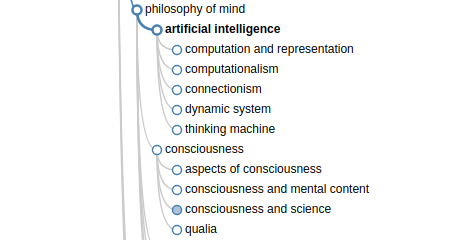

In [2]:
vocab_dict = {
    'philosophy of mind': 0,
    'artificial intelligence': 1,
    'computation and representation': 2,
    'computationalism': 3,
    'connectionism': 4,
    'dynamic system': 5,
    'thinking machine': 6,
    'consciousness': 7,
    'aspects of consciousness': 8,
    'consciousness and mental content': 9,
    'consciousness and science': 10,
    'qualia': 11}

The transitive closure matrix should then look like this:

In [205]:
trans_closure_und = np.array([
    [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],])
trans_closure_dir = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],])

In [55]:
# Global variables
vocab_size = trans_closure.shape[0]
embed_dim = 2
stability = 1e-6

In [5]:
#
# Data preparation

def get_pos_pairs(closure, n_words):
    pos_pairs = []
    for u in range(n_words):
        children = [v for v in np.nonzero(closure[u])[0]]
        if len(children) > 0:
            pos_pairs += list(zip([u] * len(children), children))
    return pos_pairs

def neg_samples(u, v, n_negs, closure):
    children = [vp for vp in np.nonzero(closure[u])[0]]
    nonchildren = [vp for vp in range(vocab_size)
                   if (vp not in children)]  # will capture u as we are supposed to
    num_negs = min(len(nonchildren), n_negs)
    return random.sample(nonchildren, num_negs)

def epoch_data(n_negs, n_words, closure):
    pos_pairs = get_pos_pairs(closure, n_words)
    # randomize order each epoch
    random.shuffle(pos_pairs)
    return [(u, v, neg_samples(u, v, n_negs, closure)) for u, v in pos_pairs]

In [65]:
#
# Math funcs

def arcosh(x):
    return torch.log(x + torch.sqrt(x**2 - 1))

def pdist(u, v):
    """Poincare distance."""
    uu = u.norm(dim=1)**2
    vv = v.norm(dim=1)**2
    uv = u.mm(v.t())
    numerator = uu - 2 * uv + vv
    denominator = (1 - uu).clamp(min=stability) * (1 - vv).clamp(min=stability)
    gamma = (1 + 2 * numerator / denominator).clamp(min=1 + stability)
    distance = arcosh(gamma)
    return distance

In [220]:
#
# Model

def loss(u, v, negs):
    """Loss for a positive pairs and negative samples.
    
    u, v, negs are all tensors by now (negs is matrix)
    """
    return -torch.log(torch.exp(-pdist(u, v)) / torch.exp(-pdist(u, negs)).sum())

In [128]:
#
# Optimization

def proj(theta):
    norm = theta.norm(p=2, dim=1).unsqueeze(1)
    norm[norm<1] = 1
    norm[norm>=1] += stability
    return theta.div(norm)

def scale_grad(delta):
    return ((1 - delta.norm()**2)**2) / 4. * delta

def update(embeds, lr, u_ix, v_ix, neg_ixs, u, v, negs):
    embeds[neg_ixs] -= lr*(((1-negs.norm(dim=1)**2)**2)/4.).data.unsqueeze(1)*negs.grad.data
    embeds[u_ix] -= lr*(((1-u.norm()**2)**2)/4.).data*u.grad.data
    embeds[v_ix] -= lr*(((1-v.norm()**2)**2)/4.).data*v.grad.data
    embeds = proj(embeds)

def forward(embeds, u_ix, v_ix, neg_ixs):
    """Calculate loss and gradient for the sample."""
    # unsqueezing yields row vectors; needed for vectorization of u.mm(negs^T) in pdist
    u = Variable(embeds[u_ix].unsqueeze(0), requires_grad=True)
    v = Variable(embeds[v_ix].unsqueeze(0), requires_grad=True)
    negs = Variable(embeds[neg_ixs], requires_grad=True)
    L = loss(u, v, negs)
    f_loss = L.data.numpy()[0][0]
    L.backward()
    return f_loss, u, v, negs

In [129]:
def pplot(vdict, pembs, name='Philosophy Ontology'):
    fig = plt.figure(figsize=(10,10)); ax = plt.gca(); ax.cla()
    ax.set_xlim((-1.1,1.1)); ax.set_ylim((-1.1,1.1))
    ax.add_artist(plt.Circle((0,0),1.,color='black',fill=False))
    fliers = []
    for w, i in vdict.items():
        emb = pembs[i]
        if emb.norm() > 1.:
            fliers.append(w)
        else:
            c0, c1 = pembs[i]
            ax.plot(c0, c1, 'o', color='y')
            ax.text(c0 +.01, c1+.01, w, color='b')
    if len(fliers) > 0:
        print('Words that flew out of the ball:')
        for flier in fliers:
            print('  * %s' % flier)
    plt.show()

In [223]:
def train(embeds, closure, vdict, n_negs, lr1, lr2):
    losses = []
    epoch = -1
    #while len(losses) < 1 or np.average(losses) > 0.01:
    while epoch < 10:
        epoch += 1
        print(epoch)
        data = epoch_data(n_negs, len(vdict), closure)
        r = 1. * epoch / 200; 
        rate = (1 - r) * lr1 + r * lr2
        if epoch < 10:
            rate = rate / 10
        for u_ix, v_ix, neg_ixs in data:
            try:
                l, u, v, negs = forward(embeds, u_ix, v_ix, neg_ixs)
                losses.append(l)
                print('Loss: %s\tAverage: %s' % (l, np.average(losses)))
                update(embeds, rate, u_ix, v_ix, neg_ixs, u, v, negs)
                pplot(vocab_dict, embeds)
            except Exception as e:
                print(embeds)
                raise e

0
Loss: 1.10089	Average: 1.10089


/home/hanshan/anaconda3/envs/py35/lib/python3.5/site-packages/torch/tensor.py:306: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub_(other)


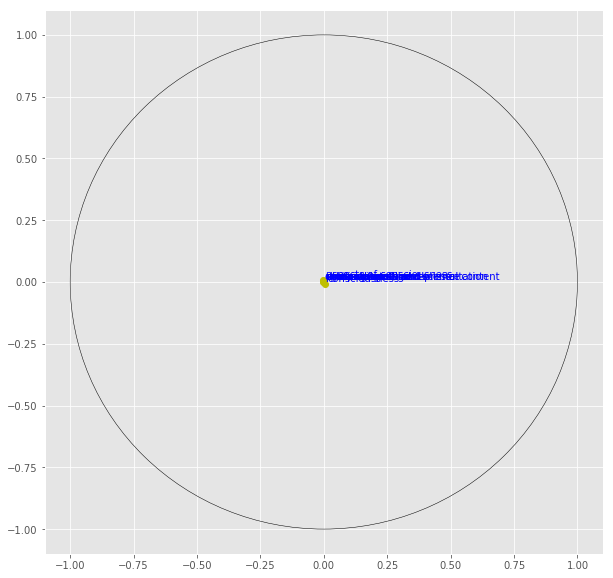

Loss: 1.10869	Average: 1.10479


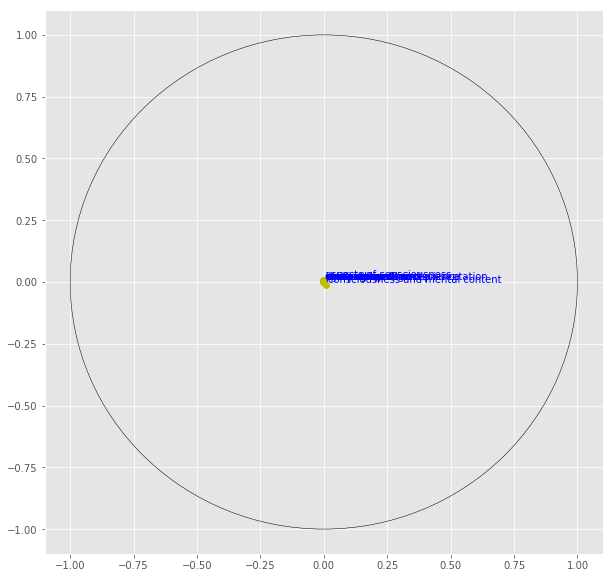

Loss: 1.0969	Average: 1.10216


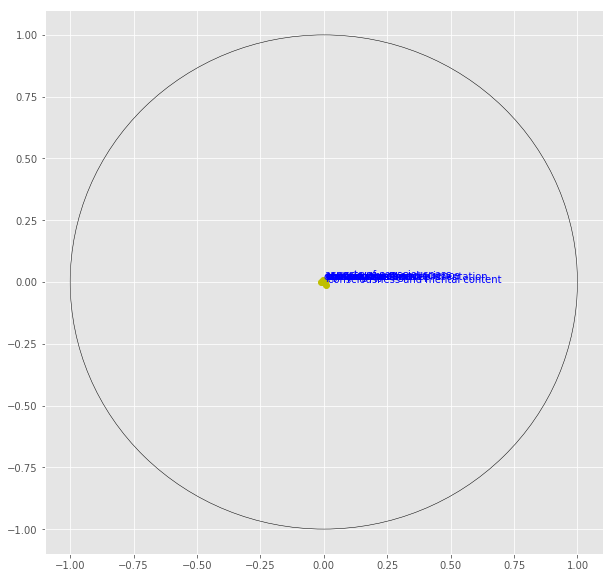

Loss: 1.097	Average: 1.10087


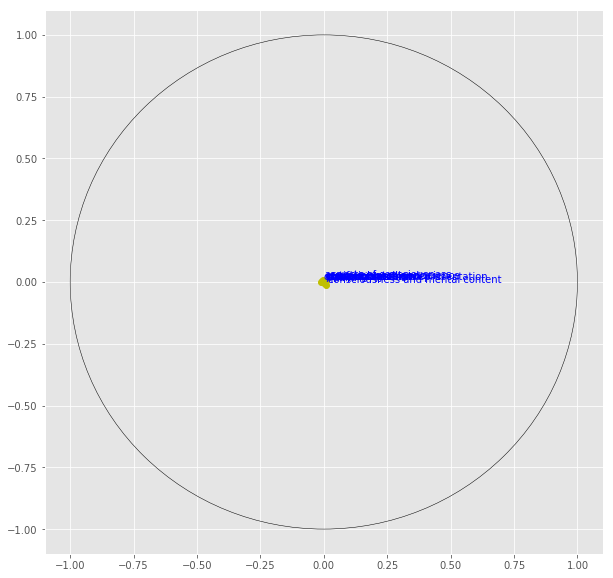

Loss: 1.1061	Average: 1.10192


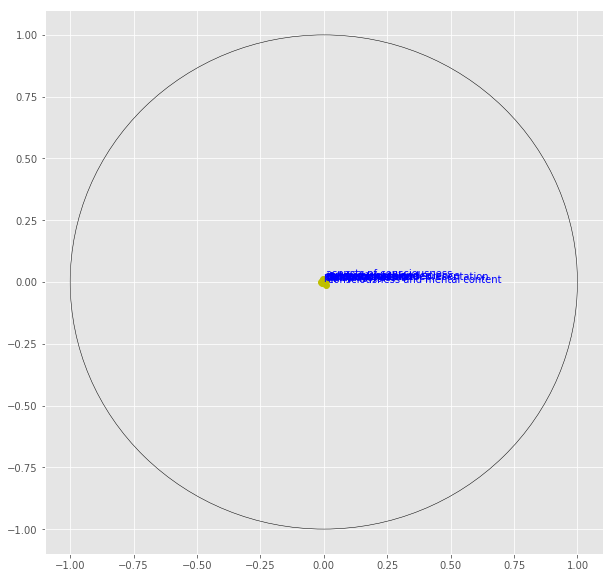

Loss: 1.10672	Average: 1.10272


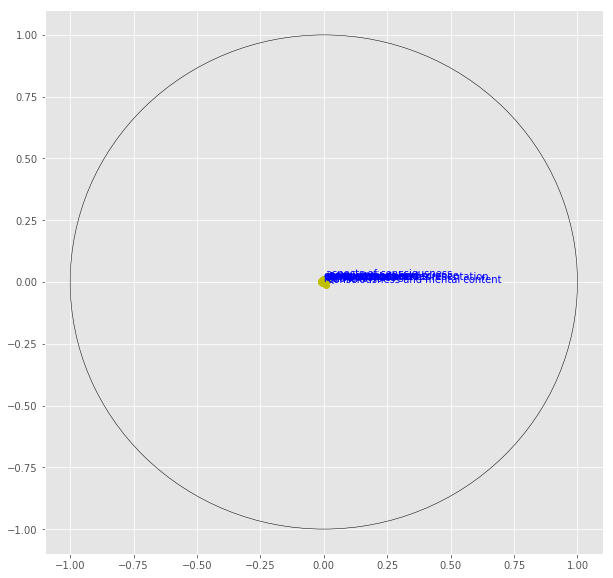

Loss: 1.08163	Average: 1.0997


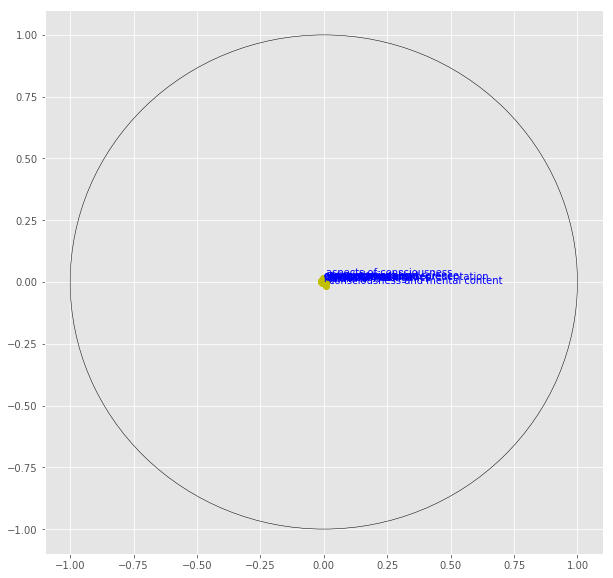

Loss: 1.12193	Average: 1.10248


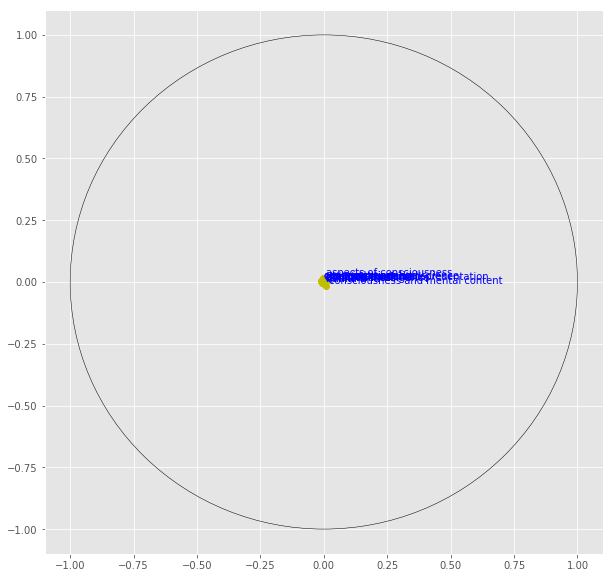

Loss: 1.08424	Average: 1.10046


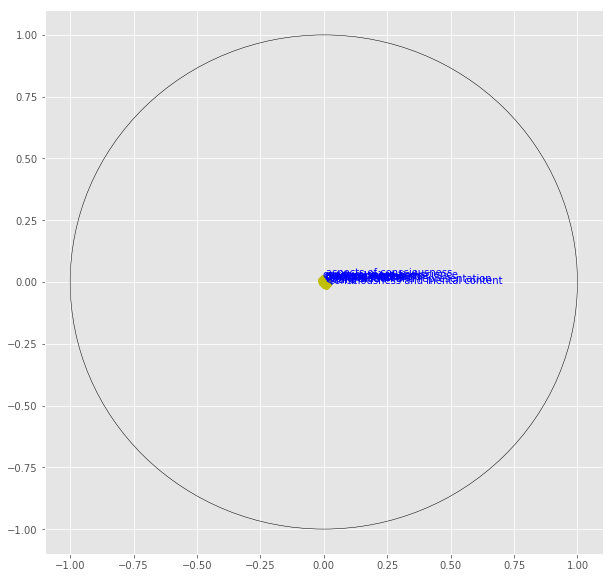

Loss: 1.07366	Average: 1.09778


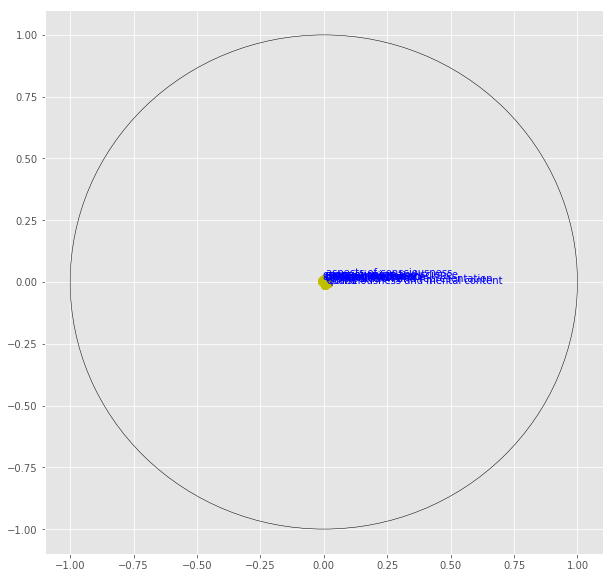

Loss: 1.09112	Average: 1.09717


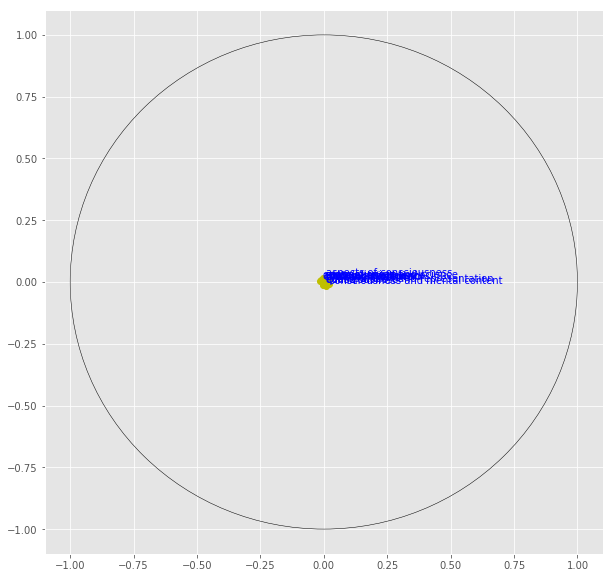

1
Loss: 1.12743	Average: 1.09969


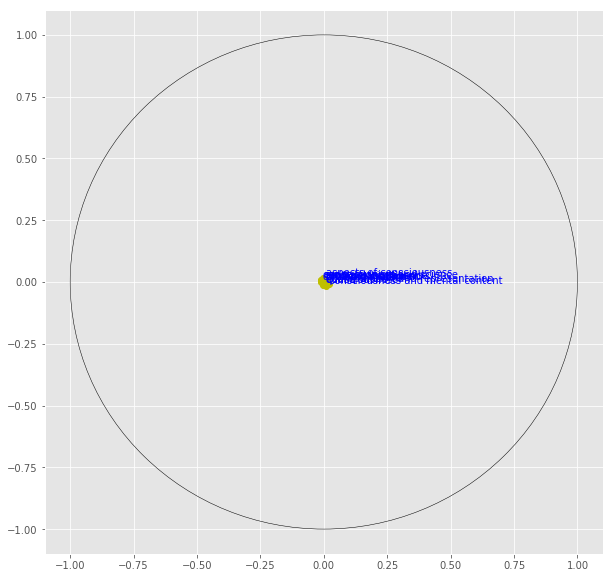

Loss: 1.10536	Average: 1.10013


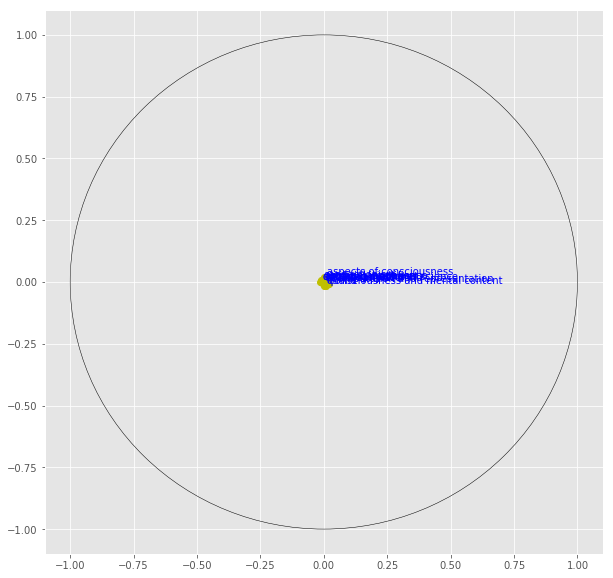

Loss: 1.11019	Average: 1.10085


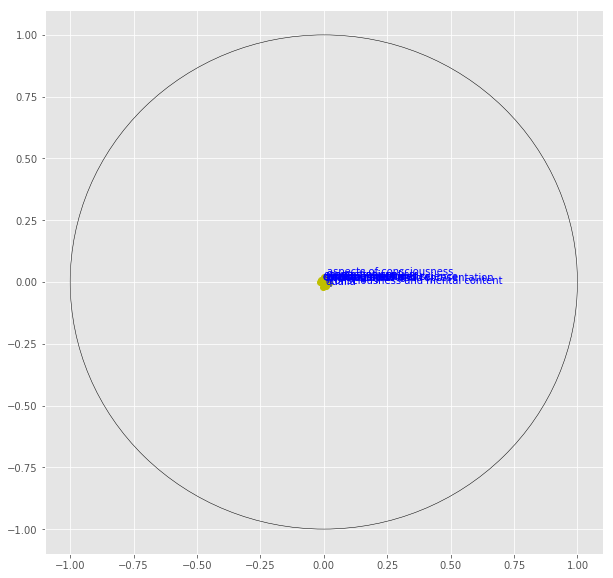

Loss: 1.10795	Average: 1.10132


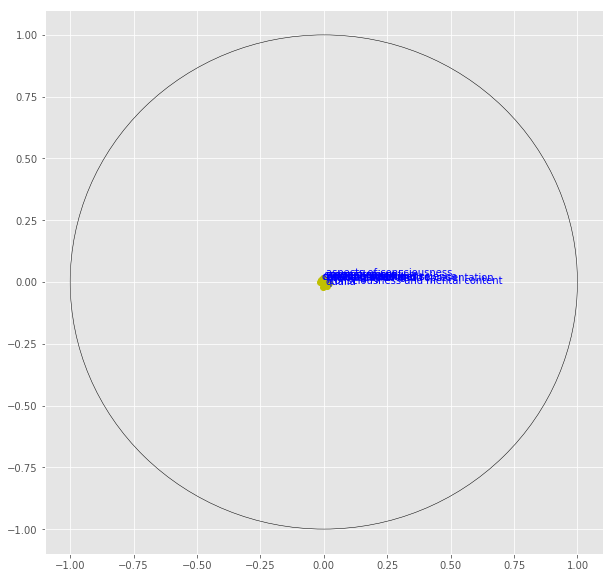

Loss: 1.11713	Average: 1.10231


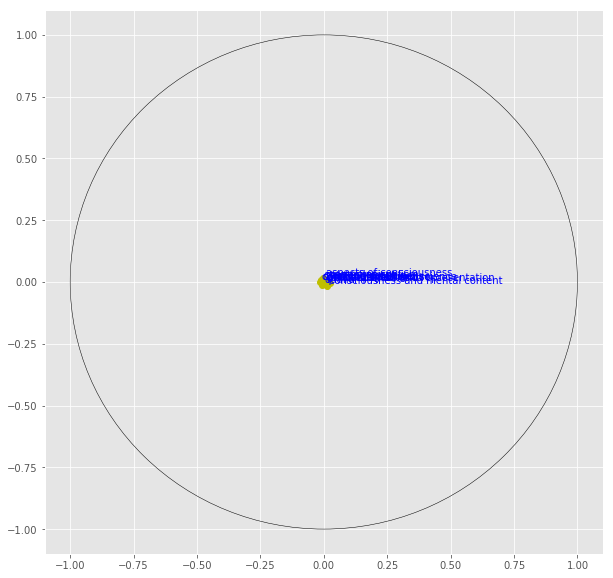

Loss: 1.09795	Average: 1.10205


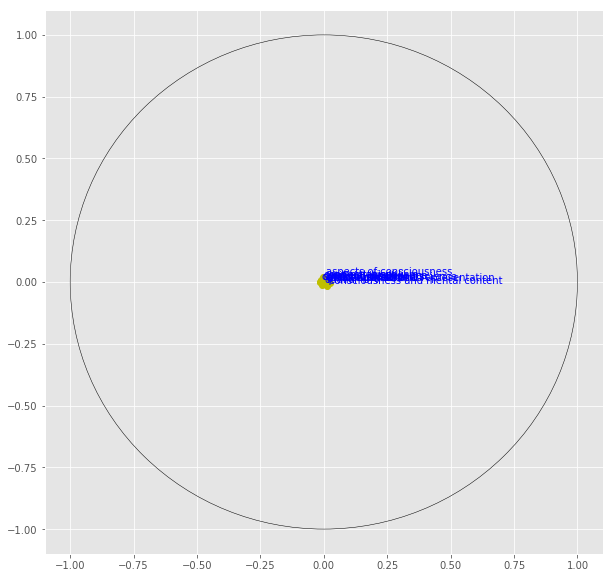

Loss: 1.09902	Average: 1.10188


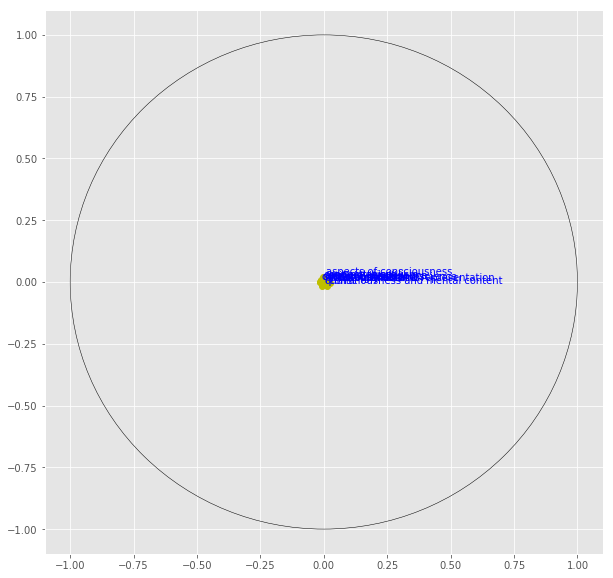

Loss: 1.07408	Average: 1.10042


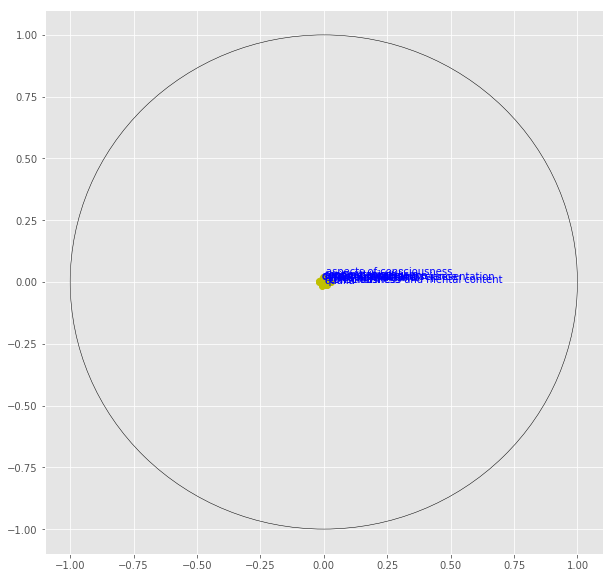

Loss: 1.09894	Average: 1.10035


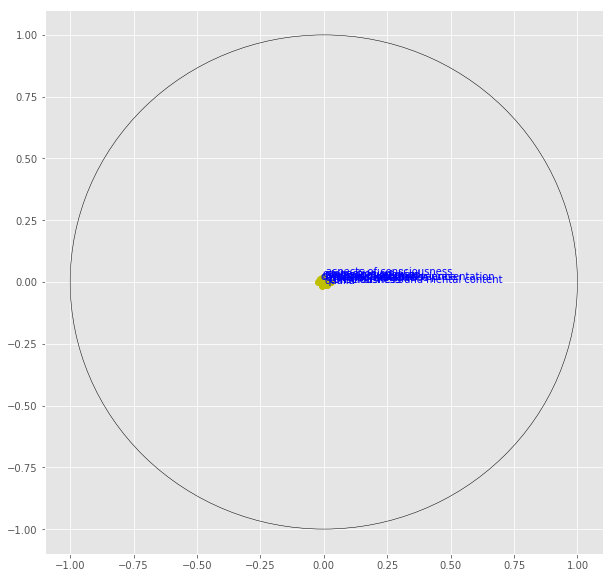

Loss: 1.07437	Average: 1.09911


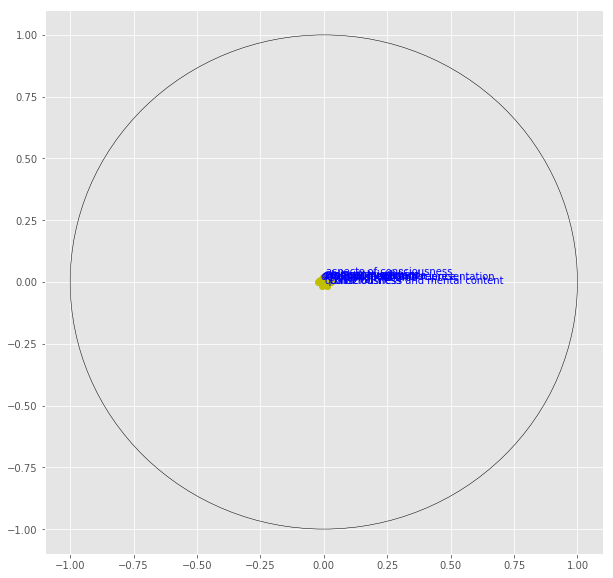

Loss: 1.05329	Average: 1.09703


KeyboardInterrupt: 

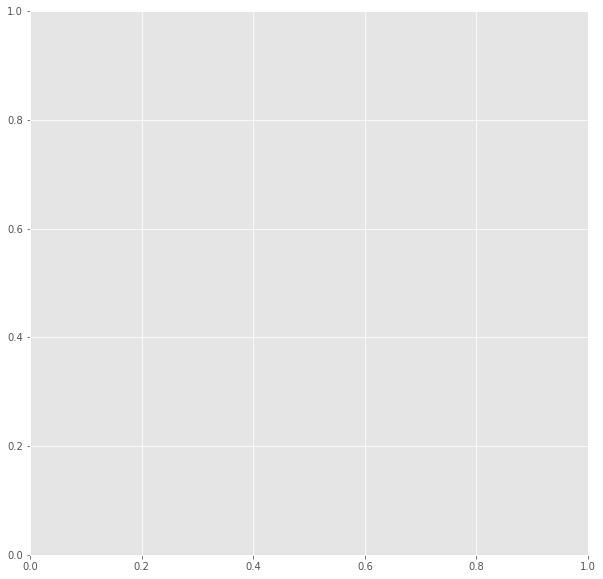

In [224]:
embeddings = torch.Tensor(vocab_size, embed_dim)
torch.nn.init.uniform(embeddings, a=-0.001, b=0.001)
train(embeddings, trans_closure_dir, vocab_dict, 3, 0.2, 0.01)

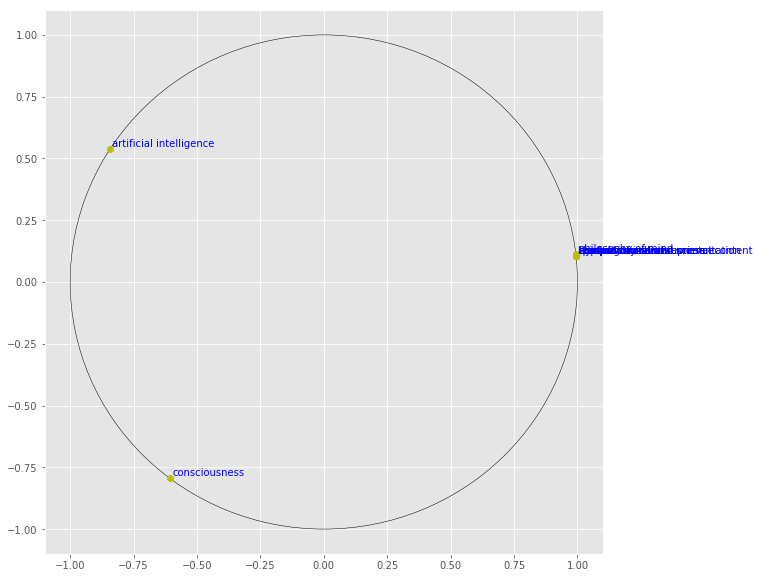

In [217]:
pplot(vocab_dict, embeddings)

In [211]:
embeddings2 = torch.Tensor(vocab_size, embed_dim)
torch.nn.init.uniform(embeddings2, a=-0.001, b=0.001)
train(embeddings2, trans_closure_und, vocab_dict, 4, 0.2, 0.01)

Loss: 1.38593	Average: 1.38593
Loss: 1.38721	Average: 1.38657
Loss: 1.41022	Average: 1.39445
Loss: 1.3861	Average: 1.39236
Loss: 1.37608	Average: 1.38911
Loss: 1.38191	Average: 1.38791
Loss: 1.41642	Average: 1.39198
Loss: 1.36035	Average: 1.38803
Loss: 1.36234	Average: 1.38517
Loss: 1.43893	Average: 1.39055
Loss: 1.38667	Average: 1.39019
Loss: 1.3745	Average: 1.38889
Loss: 1.41616	Average: 1.39098
Loss: 1.36556	Average: 1.38917
Loss: 1.33877	Average: 1.38581
Loss: 1.40504	Average: 1.38701
Loss: 1.37828	Average: 1.3865
Loss: 1.36414	Average: 1.38526
Loss: 1.39083	Average: 1.38555
Loss: 1.32865	Average: 1.3827
Loss: 1.33587	Average: 1.38047
Loss: 1.38967	Average: 1.38089
Loss: 1.3523	Average: 1.37965
Loss: 1.38919	Average: 1.38005
Loss: 1.3938	Average: 1.3806
Loss: 1.32981	Average: 1.37864
Loss: 1.34048	Average: 1.37723
Loss: 1.33859	Average: 1.37585
Loss: 1.29773	Average: 1.37316
Loss: 1.32923	Average: 1.37169
Loss: 1.33709	Average: 1.37058
Loss: 1.35216	Average: 1.37
Loss: 1.35589	Aver

/home/hanshan/anaconda3/envs/py35/lib/python3.5/site-packages/torch/tensor.py:306: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub_(other)


Loss: 1.09471	Average: 1.24867
Loss: 0.878741	Average: 1.24617
Loss: 0.833795	Average: 1.2434
Loss: 1.13042	Average: 1.24265
Loss: 1.15575	Average: 1.24207
Loss: 1.24194	Average: 1.24207
Loss: 1.12267	Average: 1.24129
Loss: 0.980101	Average: 1.23959
Loss: 1.39197	Average: 1.24058
Loss: 1.01717	Average: 1.23914
Loss: 1.3215	Average: 1.23967
Loss: 0.991496	Average: 1.2381
Loss: 1.02202	Average: 1.23674
Loss: 1.22059	Average: 1.23664
Loss: 1.12339	Average: 1.23594
Loss: 1.05115	Average: 1.23479
Loss: 1.11017	Average: 1.23403
Loss: 1.01265	Average: 1.23268
Loss: 0.784251	Average: 1.22996
Loss: 1.40161	Average: 1.231
Loss: 1.12129	Average: 1.23034
Loss: 1.03589	Average: 1.22918
Loss: 1.12435	Average: 1.22856
Loss: 0.750432	Average: 1.22575
Loss: 0.950221	Average: 1.22414
Loss: 1.17601	Average: 1.22386
Loss: 0.967067	Average: 1.22237
Loss: 0.706859	Average: 1.21941
Loss: 1.26733	Average: 1.21968
Loss: 1.22816	Average: 1.21973
Loss: 1.51456	Average: 1.2214
Loss: 0.959291	Average: 1.21993
Loss

Loss: -3.86852	Average: 0.713761
Loss: 0.7621	Average: 0.713869
Loss: 0.148062	Average: 0.712606
Loss: -1.65497	Average: 0.707333
Loss: 0.299456	Average: 0.706427
Loss: 1.15429	Average: 0.70742
Loss: -0.233886	Average: 0.705337
Loss: 0.32442	Average: 0.704496
Loss: 1.019	Average: 0.705189
Loss: -4.04974	Average: 0.694739
Loss: 0.134376	Average: 0.69351
Loss: 0.296103	Average: 0.69264
Loss: -4.27899	Average: 0.681785
Loss: -0.144479	Average: 0.679985
Loss: 1.2982	Average: 0.681329
Loss: 0.478572	Average: 0.680889
Loss: 3.54423	Average: 0.687087
Loss: 0.401761	Average: 0.68647
Loss: 0.848018	Average: 0.686819
Loss: 0.303648	Average: 0.685995
Loss: 0.589932	Average: 0.685788
Loss: 0.594816	Average: 0.685594
Loss: -4.05315	Average: 0.675468
Loss: 1.11688	Average: 0.676409
Loss: 0.351506	Average: 0.675718
Loss: -4.26901	Average: 0.66522
Loss: -0.161967	Average: 0.663467
Loss: 0.920431	Average: 0.66401
Loss: 2.9156	Average: 0.668761
Loss: 2.42713	Average: 0.672462
Loss: 3.73277	Average: 0.67

Loss: 1.21459	Average: 0.043742
Loss: 5.04612	Average: 0.0502896
Loss: 0.486733	Average: 0.0508602
Loss: 0.545788	Average: 0.0515063
Loss: -4.00075	Average: 0.046223
Loss: 0.0891251	Average: 0.0462789
Loss: -0.13589	Average: 0.046042
Loss: 1.79922	Average: 0.0483188
Loss: 0.890198	Average: 0.0494108
Loss: 1.20999	Average: 0.0509142
Loss: -8.8582	Average: 0.0393888
Loss: 5.12013	Average: 0.0459531
Loss: 4.81131	Average: 0.0521019
Loss: 0.644503	Average: 0.0528653
Loss: 1.30049	Average: 0.054471
Loss: -4.63979	Average: 0.0484372
Loss: 0.266024	Average: 0.0487166
Loss: 1.28221	Average: 0.0502979
Loss: 0.510507	Average: 0.0508872
Loss: -8.89713	Average: 0.0394447
Loss: 0.324881	Average: 0.0398093
Loss: 0.268381	Average: 0.0401008
Loss: -8.59034	Average: 0.0291066
Loss: 1.04862	Average: 0.0304037
Loss: 0.0779563	Average: 0.0304641
Loss: 0.132087	Average: 0.0305931
Loss: 0.421462	Average: 0.0310885
Loss: 0.0972114	Average: 0.0311722
Loss: 5.68901	Average: 0.0383249
Loss: 0.249338	Average: 0.

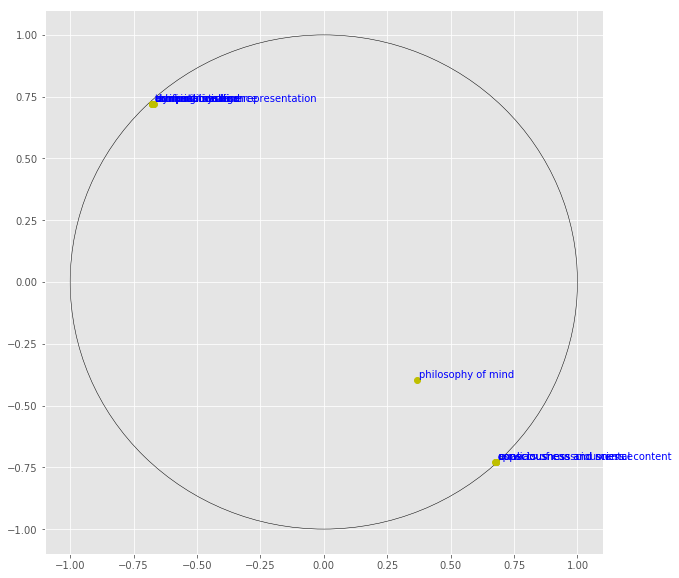

In [212]:
pplot(vocab_dict, embeddings2)

Interesting result: it looks like the higher number of nodes on the right pushes the root node off to the left.

I really don't like this loss function and I suspect a better one may be superior.

I should also try a larger tree. Although the smaller tree is a nice way to get a feel for the dynamics of the learning algorithm.

The undirected transitive closure is also bollocks. I need to double check that concept.

I also need to try the author's own dataset.

To do:
1) tidy this code
2) try and visualize how the learning algorithm works
3) double check my understanding of transitive closure
4) try the wordnet experiment (mammals at least)
5) experiment with different loss functions

Mini-batch it? Nah, got to get it stable first...

Intuition:
- The u in the top term seems key - if it was the child in the hypernymy relationship, that might on average stabilize the pos-neg loss, minimizing the distance to any potential children in that tree (although I guess no guarantee). Actually, no, that doesn't sound right.